In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [504]:
from scipy.stats import beta, multivariate_normal, uniform
from scipy.misc import derivative
import numpy as np
import matplotlib.pyplot as plt
import copy
import pandas as pd

Use the (local) shape of the distribution to make smarter proposals.

Hamiltonian: quantity that is conserved regardless of position in space.

Metaphor: hockey puck sliding on a (non-flat) surface. Want to be able to describe the state of the puck. The state has two quantities: 

1. Current position, $q$
2. Momentum, $p$

Hamiltonian: $H(q, p) = U(q) + K(p)$

* $U(q)$ -- potential energy
* $K(p)$ -- kinetic energy

In [505]:
dtarget = lambda x: multivariate_normal.pdf(x, mean=(3, 10), cov=[[1, 0], [0, 1]])
x1 = np.linspace(-6, 12, 101)
x2 = np.linspace(-11, 31, 101)
X, Y = np.meshgrid(x1, x2)
Z = np.array(map(dtarget, zip(X.flat, Y.flat))).reshape(101, 101)

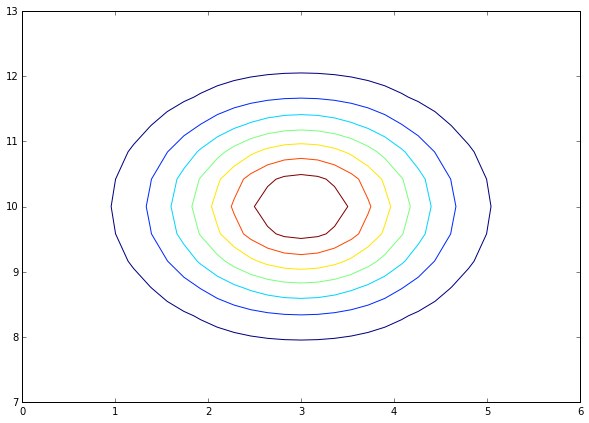

In [506]:
plt.figure(figsize=(10,7))
plt.contour(X, Y, Z)
plt.xlim(0, 6)
plt.ylim(7, 13)
plt.show()

The surface of interest will be $U(q) = -\log{f(q)}$

$K(p) = \frac{p^T p}{2m}$, where $m$ = mass of the puck.

Position over time is a function of momentum: 
$\frac{dq_i}{dt} = \frac{p_i}{m}$

Change in momentum over time is a function of surface gradient:
$\frac{dp_i}{dt} = -\frac{\delta U}{\delta q_i}$

### Leap-frog algorithm

$ p_i(t + \frac{\epsilon}{2}) = p_i(t) - \frac{\epsilon}{2} \frac{\delta U}{\delta q_i} U(q(t))$

$ q_i(t + \epsilon) = q_i(t) + \frac{\epsilon}{m}p_i(t+\frac{\epsilon}{2})$

$ p_i(t + \epsilon) = p_i(t + \frac{\epsilon}{2}) - \frac{\epsilon}{2} \frac{\delta U}{\delta q_i}(q(t+\epsilon))$

$\epsilon$ -- step size

In [507]:
def HMC_one_step(U, current_q, Eps, L, m=1):
    """
    One step of the Hamiltonian Monte Carlo.
    
    Parameters
    ----------
    U : callable
        A function that takes a single argument, the position.
    q : array-like
        Current position.
    Eps : float
        The step size, epsilon.
    L : int
        Number of leapfrog stpes.
    m : float
        Mass of the particle.
        
    Returns
    -------
    q_out : array
        Path from ``q`` to the proposed position.
    """

    q = copy.copy(current_q)
    Nq = len(q)
    p = multivariate_normal.rvs([0. for i in xrange(Nq)])
    current_p = copy.copy(p)

    out = {}
    
    out['p'] = np.zeros((L, Nq))
    out['p'][0,:] = copy.copy(p)
    out['q'] = np.zeros((L, Nq))
    out['q'][0,:] = copy.copy(q)
    
    for i in xrange(1, L):
        p -= Eps*derivative(U, q)/2.
        q += (Eps/m)*p
        out['q'][i, :] = copy.copy(q)
        p -= Eps*derivative(U, q)/2.
        out['p'][i, :] = copy.copy(p)
    
    current_U = U(current_q)
    current_K = (current_p**2).sum()/2.
    proposed_U = U(q)
    proposed_K = (p**2).sum()/2.
    
    if uniform.rvs() < exp(current_U - proposed_U + current_K - proposed_K):
        out['value'] = q
    else:
        out['value'] = current_q
    
    return out

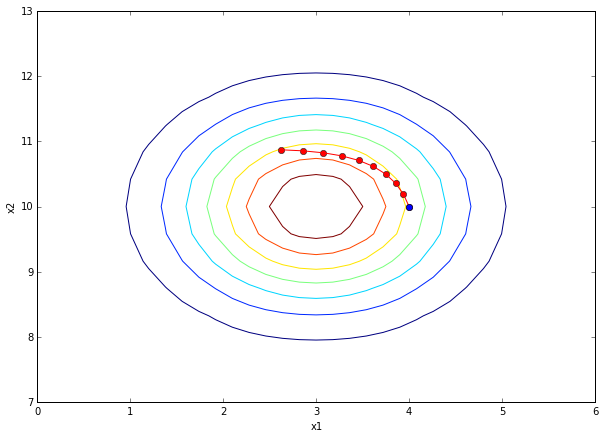

In [508]:
plt.figure(figsize=(10,7))
plt.contour(X, Y, Z)
U = lambda x: -1.*np.log(dtarget(x))
chain = HMC_one_step(U, np.array([4., 10.]), Eps=0.2, L=10, m=2)['q']
plt.plot(chain[:, 0], chain[:, 1], 'ro')
plt.plot(chain[:, 0], chain[:, 1], 'r-')
plt.plot(chain[0, 0], chain[0,1], 'bo')
plt.xlim(0, 6)
plt.ylim(7, 13)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

In [509]:
def HMC(dtarget, start, Eps=0.2, L=10, m=2, N=1000, num_chains=4):
    """
    Perform an HMC simulation.
    
    Parameters
    ----------
    dtarget : callable
        Target PDF.
    
    """
    
    # Invert the target PDF into a concave surface.
    neg_log_dtarget = lambda x: -1.*np.log(dtarget(x))
    
    # If only one starting position is provided, use it for all chains.
    if len(start.shape) == 1:
        start = np.array([np.array(start) for i in xrange(num_chains)])
        
    chains = []
    for j in xrange(num_chains):
        chain = [start[j, :]]
        for i in xrange(N):
            proposal = HMC_one_step(neg_log_dtarget, 
                                    copy.copy(chain[-1]), 
                                    Eps, L, m)['value']
            chain.append(proposal)
        chains.append(np.array(chain))
    return np.array(chains)        

Tuning parameters: step size, number of steps, and "mass" 

HMC does not work discrete parameters. STAN is all HMC.

Gelman metric still applies -- we just have a better way of proposing values.

In [510]:
def Gelman(chains):
    if len(chains.shape) == 3:
        N_p = chains.shape[2]
    else:
        N_p = 1
    generate = lambda ptn: np.array([np.array([np.array([ptn(p, i, c) 
                                                         for p in xrange(N_p)
                                               for i in xrange(chains.shape[1])])
                                     for c in xrange(chains.shape[0])])])
    params = generate(lambda p, i, c: 'x{0}'.format(p))
    iters = generate(lambda p, i, c: i)
    labels = generate(lambda p, i, c: c)
                      
    data = zip(chains.flat, params.flat, iters.flat, labels.flat)
    dataframe = pd.DataFrame(data, columns=('Value', 'Parameter', 'Iteration', 'Chain'))

    xbar = dataframe.groupby('Parameter').Value.mean()
    m = chains.shape[0]
    xbar_i = dataframe.groupby(('Parameter', 'Chain')).Value.mean()
    s2_i = dataframe.groupby(('Parameter', 'Chain')).Value.var()
    n = dataframe.groupby(('Parameter', 'Chain')).Value.count().mean()

    W = s2_i.mean()
    B = (n/(m-1.)) * ((xbar_i - xbar)**2).sum()
    sigma2_hat = W*(n-1.)/n + B/n
    R_hat = np.sqrt(sigma2_hat/W)
    n_eff = m*n*sigma2_hat/B    # I missed what this was for.
                      
    return R_hat, n_eff

In [511]:
chains = HMC(dtarget, array([4., 10.]), Eps=0.2, L=5, N=1000)

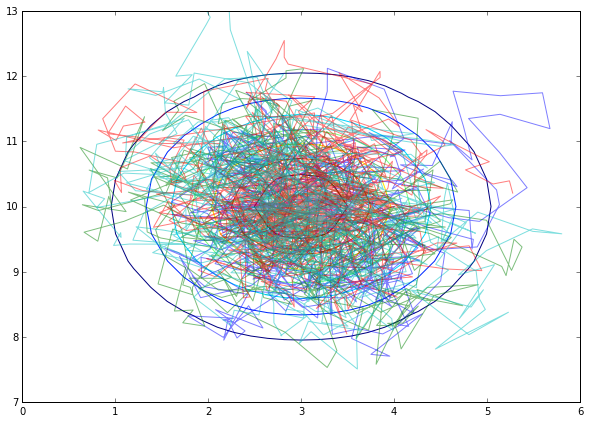

In [512]:
plt.figure(figsize=(10,7))
plt.contour(X, Y, Z)
plt.plot(chains[0][:, 0], chains[0][:, 1], alpha=0.5)
plt.plot(chains[1][:, 0], chains[1][:, 1], alpha=0.5)
plt.plot(chains[2][:, 0], chains[2][:, 1], alpha=0.5)
plt.plot(chains[3][:, 0], chains[3][:, 1], alpha=0.5)
plt.xlim(0, 6)
plt.ylim(7, 13)
plt.show()

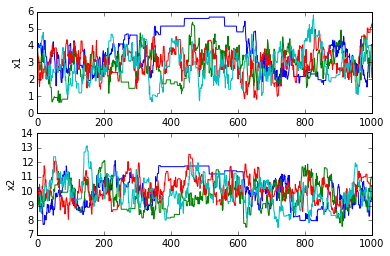

In [513]:
plt.subplot(211)
for i in xrange(chains.shape[0]):
    plt.plot(chains[i,:,0])
plt.ylabel('x1')

plt.subplot(212)
for i in xrange(chains.shape[0]):
    plt.plot(chains[i,:,1])
plt.ylabel('x2')

In [514]:
Gelman(chains)

(1.0090986190545777, 211.27211091189264)

### Banana-shaped target distribution

In [515]:
dtarget = lambda x: exp( (-x[0]**2)/200. - 0.5*(x[1]+(0.05*x[0]**2) - 100.*0.05)**2)

In [516]:
x1 = np.linspace(-20, 20, 101)
x2 = np.linspace(-15, 10, 101)
X, Y = np.meshgrid(x1, x2)
Z = np.array(map(dtarget, zip(X.flat, Y.flat))).reshape(101, 101)

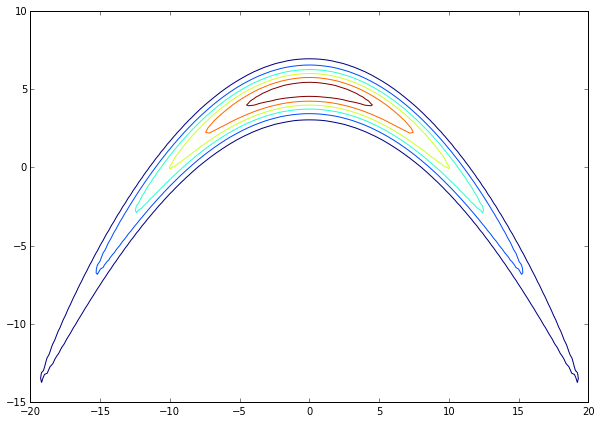

In [517]:
plt.figure(figsize=(10,7))
plt.contour(X, Y, Z)
plt.show()

In [ ]:
start = np.array([[uniform.rvs(loc=-10., scale=15.), 
                   uniform.rvs(loc=0., scale=10)]
                  for i in xrange(4)])
chains = HMC(dtarget, start, Eps=0.7, L=12, m=2, N=10000)

In [ ]:
plt.figure(figsize=(10,7))
plt.contour(X, Y, Z)

plt.plot(chains[0][:, 0], chains[0][:, 1], alpha=0.5)
plt.plot(chains[1][:, 0], chains[1][:, 1], alpha=0.5)
plt.plot(chains[2][:, 0], chains[2][:, 1], alpha=0.5)
plt.plot(chains[3][:, 0], chains[3][:, 1], alpha=0.5)
plt.show()

In [ ]:
plt.subplot(211)
plt.title(Gelman(chains)[0])
for i in xrange(chains.shape[0]):
    plt.plot(chains[i,:,0])
plt.ylabel('x1')

plt.subplot(212)
for i in xrange(chains.shape[0]):
    plt.plot(chains[i,:,1])
plt.ylabel('x2')

plt.tight_layout()
plt.show()